<a href="https://colab.research.google.com/github/sonichandni/Song-Recommendations/blob/master/Song_recommendations_with_genre1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [138]:
!wget https://raw.githubusercontent.com/sonichandni/Song-Recommendations/master/songs.csv
df = pd.read_csv('songs.csv',  encoding = "ISO-8859-1")
df.head()

--2020-03-16 10:45:49--  https://raw.githubusercontent.com/sonichandni/Song-Recommendations/master/songs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202933 (198K) [text/plain]
Saving to: ‘songs.csv.2’

songs.csv.2         100%[===================>] 198.18K  --.-KB/s    in 0.005s  

2020-03-16 10:45:49 (41.3 MB/s) - ‘songs.csv.2’ saved [202933/202933]



,Song-Name,Singer/Artists,Genre,Album/Movie,User-Rating
1,Aankh Marey,"Kumar Sanu, Mika Singh, Neha Kakkar",BollywoodDance,Simmba,8.8/10
2,Coca Cola,"Neha Kakkar, Tony Kakkar",BollywoodDanceRomantic,Luka Chuppi,9.0/10
3,Apna Time Aayega,Ranveer Singh,BollywoodDance,Gully Boy,9.7/10
4,Mungda,"Jyotica Tangri, Shaan, Subhro Ganguly",BollywoodDance,Total Dhamaal,9.1/10
5,Tere Bin,"Asees Kaur, Rahat Fateh Ali Khan, Tanishk Bagchi",BollywoodRomantic,Simmba,9.2/10


In [139]:
df.shape

(2420, 5)

In [140]:
df.isnull().sum()

Song-Name          0
Singer/Artists    10
Genre              0
Album/Movie        3
User-Rating        0
dtype: int64

In [0]:
df['SongCode'] = ["SB" + str(i) for i in range(df.shape[0])]

In [142]:
df.head()

,Song-Name,Singer/Artists,Genre,Album/Movie,User-Rating,SongCode
1,Aankh Marey,"Kumar Sanu, Mika Singh, Neha Kakkar",BollywoodDance,Simmba,8.8/10,SB0
2,Coca Cola,"Neha Kakkar, Tony Kakkar",BollywoodDanceRomantic,Luka Chuppi,9.0/10,SB1
3,Apna Time Aayega,Ranveer Singh,BollywoodDance,Gully Boy,9.7/10,SB2
4,Mungda,"Jyotica Tangri, Shaan, Subhro Ganguly",BollywoodDance,Total Dhamaal,9.1/10,SB3
5,Tere Bin,"Asees Kaur, Rahat Fateh Ali Khan, Tanishk Bagchi",BollywoodRomantic,Simmba,9.2/10,SB4


In [143]:
songs = df["Genre"].unique().tolist()
len(songs)

21

In [0]:
# shuffle song ID's
random.shuffle(songs)

# extract 90% of song ID's
song_train = [songs[i] for i in range(round(0.9*len(songs)))]

# split data into train and validation set
train_df = df[df['Genre'].isin(song_train)]
validation_df = df[~df['Genre'].isin(song_train)]

In [145]:
# list to capture the genre
like_train = []

# populate the list with the product codes
for i in tqdm(song_train):
    temp = train_df[train_df["Genre"] == i]["SongCode"].tolist()
    like_train.append(temp)

100%|██████████| 19/19 [00:00<00:00, 950.65it/s]


In [146]:
# list to capture the genre
like_val = []

# populate the list with the song codes
for i in tqdm(validation_df['Genre'].unique()):
    temp = validation_df[validation_df["Genre"] == i]["SongCode"].tolist()
    like_val.append(temp)

100%|██████████| 2/2 [00:00<00:00, 510.88it/s]


In [0]:
# train word2vec model
model = Word2Vec(window = 5, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14, min_count=1)

model.build_vocab(like_train, progress_per=200)

In [148]:
model.train(like_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(23810, 23810)

In [0]:
model.init_sims(replace=True)

In [150]:
print(model)

Word2Vec(vocab=2381, size=100, alpha=0.03)


In [0]:
# # extract all vectors
# X = model[model.wv.vocab]

# X.shape
# test = model.wv.most_similar('SB1057')
# # for t in test:
# #   for d in df:
#     # print(d.type)
#     # # if(d['SongCode'] == t[0]):
#     #   print(d['Song-Name'])
#     #   print(t[0])
# # df.head()
# test
# # df.loc[df['SongCode'].isin(test[0])]
# # df.loc[df['SongCode'] == 'SB1']


In [0]:
# columns = list(df)
# data = []
# df1 = pd.DataFrame(columns = df.columns)
# for t in test:
#   c = df.loc[lambda df: df['SongCode'] == t[0]]
#   print(c.values)
#   # zipped = zip(columns, c.values)
#   # a_dictionary = dict(zipped)
#   # print(a_dictionary)
#   data.append(c.values)

# # 
# # df1 = df1.append(data, True)
# # # df1 = pd.DataFrame(data, columns=columns)
# # df1 = pd.DataFrame(data=data,columns=df.columns)
# # df1

In [0]:
# columns = list(df)
# data = []
# df1 = pd.DataFrame(columns = df.columns)
# for t in test:
#   df1 = df.loc[df['SongCode'] == t[0]]
#   df1 = df.loc[lambda df: df['SongCode'] == t[0]]
  
# df1

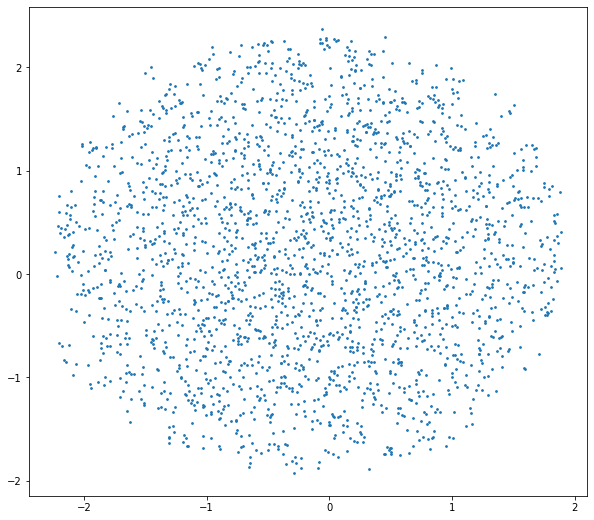

In [153]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [0]:
sng = train_df[["SongCode", "Song-Name","Genre"]]
# sng
# remove duplicates
# sng.drop_duplicates(inplace=True, subset='SongCode', keep="last")

# # create song-ID and Song-Name dictionary
sng_dict = sng.groupby('SongCode')['Song-Name'].apply(list).to_dict()
# sng_dict

In [155]:
# test the dictionary
sng_dict['SB649']

['Subhanallah']

In [0]:
def similar_songs(v, n = 6):
    
    # extract most similar song for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    # print(ms)
    # print(sng_dict)
    # extract name and similarity score of the similar song
    new_ms = []
    for j in ms:
        pair = (sng_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms    

In [157]:
similar_songs(model['SB649'])

[('Musafir', 0.6709380745887756),
 ('Tu Hi Meri Shab Hai', 0.6442582607269287),
 ('Koi Mil Gaya', 0.6425020694732666),
 ('Aap Ki Nazron Ne Samjha', 0.635926365852356),
 ('Meri Khamoshi Hai', 0.6357775926589966),
 ('Dooriyan', 0.6345308423042297)]